In [19]:
import numpy as np
import pandas as pd
import cv2
from dotenv import load_dotenv
import os
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [20]:
load_dotenv()

True

In [21]:
image_128_path = os.getenv("IMAGE_256_PATH")


In [22]:
image_paths_128 = [os.path.join(image_128_path,path) for path in os.listdir(image_128_path)]
image_paths_128[0:5]

['D:/Urban Sound Classification/image_dataset/256\\air_conditioner_1169.png',
 'D:/Urban Sound Classification/image_dataset/256\\air_conditioner_1170.png',
 'D:/Urban Sound Classification/image_dataset/256\\air_conditioner_1326.png',
 'D:/Urban Sound Classification/image_dataset/256\\air_conditioner_1327.png',
 'D:/Urban Sound Classification/image_dataset/256\\air_conditioner_1328.png']

(400, 587, 3)


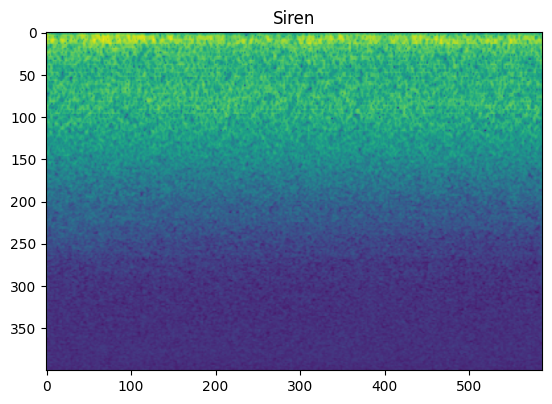

In [23]:
import matplotlib.pyplot as plt
import random

def visualize_random_image(image_paths):
    random_idx = random.randint(0, len(image_paths)-1)
    image_path = image_paths[random_idx]
    # Get class name from path
    class_name = image_path.split('\\')[-1].split('_')[0].replace('_', ' ').title()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    print(image.shape)
    plt.imshow(image)
    plt.title(class_name)
    #plt.axis('off')
    plt.show()

visualize_random_image(image_paths_128)

### Generate Pytorch Dataset

In [24]:
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
class UrbanDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ## resize image to 256x256
        image = cv2.resize(image,(256,256))
        
        # Convert to PyTorch tensor and normalize to [0,1]
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1) # Change from HWC to CHW format
        image = image / 255.0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_image_paths(self):
        return self.image_paths
    
    def get_labels(self):
        return self.labels
    
    def get_image_path(self, idx):
        return self.image_paths[idx]
    
    def get_label(self, idx):
        return self.labels[idx]
    
    def get_class_name(self, idx):
        image_path = self.image_paths[idx]
        class_name = image_path.split('\\')[-1].split('_')[0].replace('_', ' ').title()
        return class_name

In [25]:
from sklearn.preprocessing import LabelEncoder

# Get class names from paths
labels_128 = [path.split('\\')[-1].split('_')[0].replace('_', ' ').title() for path in image_paths_128]

# Encode labels and create mapping dictionary
label_encoder = LabelEncoder()
labels_128 = label_encoder.fit_transform(labels_128)

# Create dictionary mapping numeric labels to class names
label_to_class = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# Show unique labels and mapping
print("Unique numeric labels:", np.unique(labels_128))
print("\nLabel to class mapping:")
for label, class_name in label_to_class.items():
    print(f"{label}: {class_name}")

Unique numeric labels: [0 1 2 3 4 5 6 7 8 9]

Label to class mapping:
0: Air
1: Car
2: Children
3: Dog
4: Drilling
5: Engine
6: Gun
7: Jackhammer
8: Siren
9: Street


### Train Test Split and DataLoaders

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_paths_128,labels_128,stratify=labels_128,test_size=0.2,random_state=42)

In [27]:
train_dataset = UrbanDataset(X_train,y_train)   
test_dataset = UrbanDataset(X_test,y_test)

In [28]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.layer1 = self.ConvModule(in_channels=3, out_channels=32)
        self.layer2 = self.ConvModule(in_channels=32, out_channels=64)
        self.layer3 = self.ConvModule(in_channels=64, out_channels=128)
        self.layer4 = self.ConvModule(in_channels=128, out_channels=256)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

    def ConvModule(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
from torchvision import models

### vgg16
vgg16 = models.vgg16(pretrained=True)


c:\Users\Beytullah\anaconda3\envs\visea-uludag\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Beytullah\anaconda3\envs\visea-uludag\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

c:\Users\Beytullah\anaconda3\envs\visea-uludag\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 219/219 [04:22<00:00,  1.20s/it]


Saved better model to models/model_epoch_1_loss_1.0980.pth
Epoch [1/100]
Train Loss: 2.0101, Train Acc: 0.4588
Test Loss: 1.0980, Test Acc: 0.6113
--------------------


100%|██████████| 219/219 [02:25<00:00,  1.51it/s]


Saved better model to models/model_epoch_2_loss_0.9102.pth
Epoch [2/100]
Train Loss: 1.0030, Train Acc: 0.6563
Test Loss: 0.9102, Test Acc: 0.6857
--------------------


100%|██████████| 219/219 [02:24<00:00,  1.51it/s]


Saved better model to models/model_epoch_3_loss_0.6351.pth
Epoch [3/100]
Train Loss: 0.7218, Train Acc: 0.7611
Test Loss: 0.6351, Test Acc: 0.7968
--------------------


100%|██████████| 219/219 [02:13<00:00,  1.64it/s]


Saved better model to models/model_epoch_4_loss_0.5442.pth
Epoch [4/100]
Train Loss: 0.5402, Train Acc: 0.8253
Test Loss: 0.5442, Test Acc: 0.8220
--------------------


100%|██████████| 219/219 [02:26<00:00,  1.49it/s]


Epoch [5/100]
Train Loss: 0.3884, Train Acc: 0.8719
Test Loss: 0.6686, Test Acc: 0.8025
--------------------


100%|██████████| 219/219 [01:17<00:00,  2.83it/s]


Epoch [6/100]
Train Loss: 0.3204, Train Acc: 0.8939
Test Loss: 0.7380, Test Acc: 0.8014
--------------------


100%|██████████| 219/219 [01:01<00:00,  3.53it/s]


Saved better model to models/model_epoch_7_loss_0.4119.pth
Epoch [7/100]
Train Loss: 0.2623, Train Acc: 0.9122
Test Loss: 0.4119, Test Acc: 0.8781
--------------------


100%|██████████| 219/219 [01:20<00:00,  2.71it/s]


Epoch [8/100]
Train Loss: 0.2225, Train Acc: 0.9266
Test Loss: 0.4709, Test Acc: 0.8672
--------------------


100%|██████████| 219/219 [01:02<00:00,  3.52it/s]


Saved better model to models/model_epoch_9_loss_0.3321.pth
Epoch [9/100]
Train Loss: 0.1635, Train Acc: 0.9472
Test Loss: 0.3321, Test Acc: 0.8987
--------------------


100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch [10/100]
Train Loss: 0.1388, Train Acc: 0.9543
Test Loss: 0.4591, Test Acc: 0.8758
--------------------


100%|██████████| 219/219 [01:02<00:00,  3.52it/s]


Epoch [11/100]
Train Loss: 0.1495, Train Acc: 0.9503
Test Loss: 0.4083, Test Acc: 0.8878
--------------------


100%|██████████| 219/219 [01:01<00:00,  3.54it/s]


Epoch [12/100]
Train Loss: 0.1173, Train Acc: 0.9626
Test Loss: 0.5327, Test Acc: 0.8620
--------------------


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [13/100]
Train Loss: 0.0796, Train Acc: 0.9739
Test Loss: 0.3968, Test Acc: 0.9096
--------------------


100%|██████████| 219/219 [01:04<00:00,  3.37it/s]


Epoch [14/100]
Train Loss: 0.0864, Train Acc: 0.9715
Test Loss: 0.4319, Test Acc: 0.9004
--------------------


100%|██████████| 219/219 [01:05<00:00,  3.36it/s]


Epoch [15/100]
Train Loss: 0.0717, Train Acc: 0.9762
Test Loss: 0.4551, Test Acc: 0.8981
--------------------


100%|██████████| 219/219 [01:05<00:00,  3.36it/s]


Saved better model to models/model_epoch_16_loss_0.2816.pth
Epoch [16/100]
Train Loss: 0.0313, Train Acc: 0.9897
Test Loss: 0.2816, Test Acc: 0.9342
--------------------


100%|██████████| 219/219 [01:18<00:00,  2.80it/s]


Saved better model to models/model_epoch_17_loss_0.2604.pth
Epoch [17/100]
Train Loss: 0.0127, Train Acc: 0.9970
Test Loss: 0.2604, Test Acc: 0.9359
--------------------


100%|██████████| 219/219 [01:55<00:00,  1.89it/s]


Saved better model to models/model_epoch_18_loss_0.2549.pth
Epoch [18/100]
Train Loss: 0.0096, Train Acc: 0.9971
Test Loss: 0.2549, Test Acc: 0.9376
--------------------


100%|██████████| 219/219 [01:48<00:00,  2.03it/s]


Saved better model to models/model_epoch_19_loss_0.2534.pth
Epoch [19/100]
Train Loss: 0.0081, Train Acc: 0.9981
Test Loss: 0.2534, Test Acc: 0.9416
--------------------


100%|██████████| 219/219 [01:28<00:00,  2.48it/s]


Epoch [20/100]
Train Loss: 0.0069, Train Acc: 0.9980
Test Loss: 0.2573, Test Acc: 0.9405
--------------------


100%|██████████| 219/219 [01:10<00:00,  3.12it/s]


Epoch [21/100]
Train Loss: 0.0063, Train Acc: 0.9977
Test Loss: 0.2575, Test Acc: 0.9410
--------------------


100%|██████████| 219/219 [02:00<00:00,  1.82it/s]


Epoch [22/100]
Train Loss: 0.0053, Train Acc: 0.9987
Test Loss: 0.2653, Test Acc: 0.9422
--------------------


100%|██████████| 219/219 [01:38<00:00,  2.22it/s]


Epoch [23/100]
Train Loss: 0.0052, Train Acc: 0.9983
Test Loss: 0.2628, Test Acc: 0.9416
--------------------


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [24/100]
Train Loss: 0.0046, Train Acc: 0.9984
Test Loss: 0.2644, Test Acc: 0.9399
--------------------


100%|██████████| 219/219 [01:06<00:00,  3.30it/s]


Epoch [25/100]
Train Loss: 0.0038, Train Acc: 0.9990
Test Loss: 0.2758, Test Acc: 0.9405
--------------------


100%|██████████| 219/219 [02:29<00:00,  1.47it/s]


Epoch [26/100]
Train Loss: 0.0031, Train Acc: 0.9993
Test Loss: 0.2725, Test Acc: 0.9439
--------------------


100%|██████████| 219/219 [01:40<00:00,  2.19it/s]


Epoch [27/100]
Train Loss: 0.0033, Train Acc: 0.9994
Test Loss: 0.2728, Test Acc: 0.9433
--------------------


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [28/100]
Train Loss: 0.0029, Train Acc: 0.9993
Test Loss: 0.2732, Test Acc: 0.9416
--------------------


100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Early stopping triggered after epoch 29


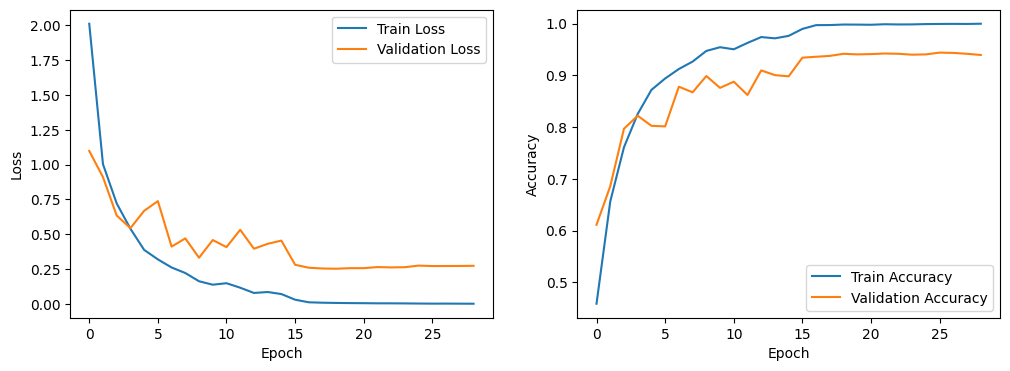

In [33]:

scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=5,verbose=True)

def train_model(model,train_loader,test_loader,criterion,optimizer,device,scheduler=scheduler,epochs=10):
    # Lists to store metrics for plotting
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    # Early stopping parameters
    best_loss = float('inf')
    patience = 10
    counter = 0
    
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images,labels in tqdm(train_loader):
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss/len(train_loader)
        train_acc = correct/total
        
        # Testing
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                test_loss += loss.item()
                _,predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = test_loss/len(test_loader)
        test_acc = correct/total
        
        # Store metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        # Save model if it has better test loss
        if test_loss < best_loss:
            best_loss = test_loss
            counter = 0
            # Save model with epoch number and test loss
            model_path = f'models/model_epoch_{epoch+1}_loss_{test_loss:.4f}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_loss': test_loss,
                'test_acc': test_acc
            }, model_path)
            print(f'Saved better model to {model_path}')
        else:
            counter += 1
            
        if counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
            
        scheduler.step(test_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('--------------------')
    
    # Plot training curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return train_losses, train_accs, test_losses, test_accs


history = train_model(model,train_loader,test_loader,criterion,optimizer,device,scheduler=scheduler,epochs=100)
train_losses, train_accs, test_losses, test_accs = history

C:\Users\Beytullah\AppData\Local\Temp\ipykernel_22456\1960770985.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_epoch_19


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       200
           1       0.96      0.94      0.95        86
           2       0.90      0.90      0.90       200
           3       0.90      0.92      0.91       200
           4       0.93      0.95      0.94       200
           5       0.98      0.95      0.97       200
           6       1.00      0.97      0.99        75
           7       0.95      0.97      0.96       200
           8       0.95      0.97      0.96       186
           9       0.93      0.89      0.91       200

    accuracy                           0.94      1747
   macro avg       0.95      0.94      0.95      1747
weighted avg       0.94      0.94      0.94      1747



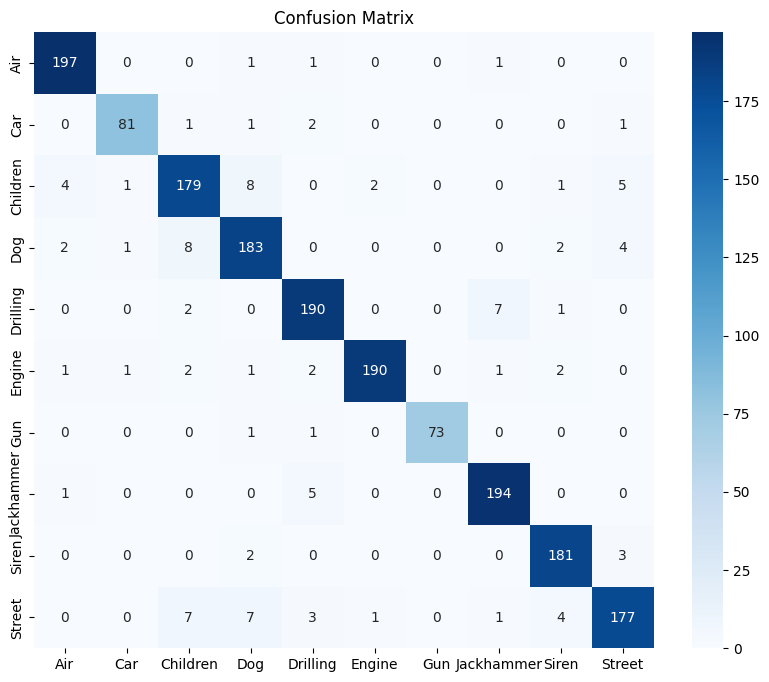

Test Loss: 0.2534, Test Acc: 0.9416


In [45]:
def evaluate_model(model,test_loader,criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images,labels in tqdm(test_loader):
            images,labels = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            running_loss += loss.item()
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss/len(test_loader)
    test_acc = correct/total
    
    # Generate classification report and confusion matrix
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(all_labels, all_preds)
    class_names = label_encoder.classes_
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.show()
    
    return test_loss, test_acc

### load existing   model
model = CustomCNN().to(device)
model.load_state_dict(torch.load('models/model_epoch_19_loss_0.2534.pth')['model_state_dict'])
test_loss,test_acc = evaluate_model(model,test_loader,criterion,device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [46]:
def predict_from_image(model,image_path,device):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(256,256))
    image = torch.from_numpy(image).float()
    image = image.permute(2,0,1)
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)

In [47]:
model

CustomCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride

In [48]:
for name,module in model.named_modules():
    print(name)


layer1
layer1.0
layer1.1
layer1.2
layer1.3
layer2
layer2.0
layer2.1
layer2.2
layer2.3
layer3
layer3.0
layer3.1
layer3.2
layer3.3
layer4
layer4.0
layer4.1
layer4.2
layer4.3
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5


In [49]:
def get_conv_layer(model,layer_name):
    for name,module in model.named_modules():
        if name == layer_name:
            return module
    raise ValueError(f"Layer {layer_name} not found in model")

In [50]:
get_conv_layer(model,'layer4.2')

ReLU(inplace=True)

In [51]:
# Function to generate Grad-CAM heatmap
def compute_gradcam(model, img_tensor, class_index, conv_layer_name="layer4.2"):
    conv_layer = get_conv_layer(model, conv_layer_name)

    # Forward hook to store activations
    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    hook = conv_layer.register_forward_hook(forward_hook)

    # Compute gradients
    img_tensor.requires_grad_(True)
    preds = model(img_tensor)
    loss = preds[:, class_index]
    model.zero_grad()
    loss.backward()

    # Get gradients
    grads = img_tensor.grad.cpu().numpy()
    pooled_grads = np.mean(grads, axis=(0, 2, 3))

    # Remove the hook
    hook.remove()

    activations = activations.detach().cpu().numpy()[0]
    for i in range(pooled_grads.shape[0]):
        activations[i, ...] *= pooled_grads[i]

    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


In [52]:
heatmap = compute_gradcam(model,train_dataset[100][0].unsqueeze(0).to(device),0,"layer4.2")

In [53]:
# Overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img

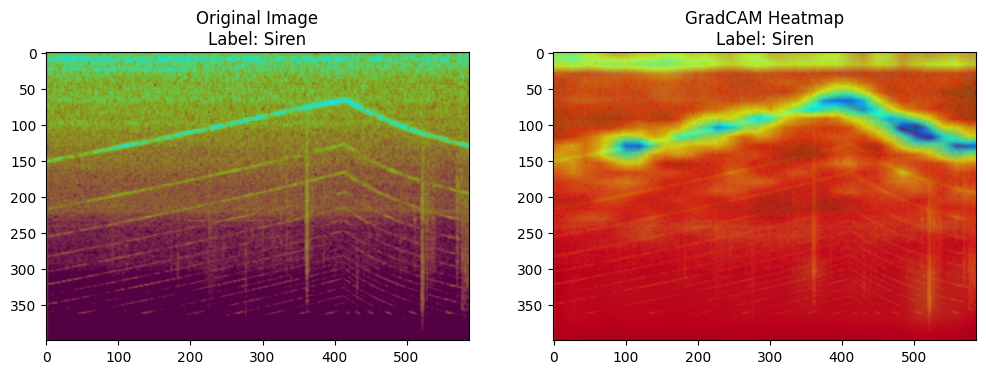

In [54]:
def visualize_gradcam(model, test_dataset, device, label_to_class):
    random_test_idx = np.random.randint(0,len(test_dataset))
    image_path = test_dataset.get_image_paths()[random_test_idx]
    label = test_dataset[random_test_idx][1]
    
    heatmap = compute_gradcam(model,test_dataset[random_test_idx][0].unsqueeze(0).to(device),0,"layer4.2")
    overlayed = overlay_heatmap(image_path,heatmap)
    original = cv2.imread(image_path,cv2.IMREAD_COLOR)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.title(f'Original Image\nLabel: {label_to_class[int(label)]}')
    plt.subplot(1,2,2) 
    plt.imshow(overlayed)
    plt.title(f'GradCAM Heatmap\nLabel: {label_to_class[int(label)]}')
    plt.show()

visualize_gradcam(model, test_dataset, device, label_to_class)